In [6]:

api=KaggleApi()
api.authenticate()
os.mkdir("data")
l=["train.csv","test.csv","store.csv"]
for i in l:
    api.competition_download_file("rossmann-store-sales",i,force=True)

ApiException: (403)
Reason: Forbidden
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json', 'Date': 'Mon, 27 Jun 2022 00:39:43 GMT', 'Access-Control-Allow-Credentials': 'true', 'Set-Cookie': 'ka_sessionid=9d67eaf8ff842e3d45146fbb6248caf4; max-age=2626560; path=/, GCLB=CIT985_4lbvGrQE; path=/; HttpOnly', 'Transfer-Encoding': 'chunked', 'Vary': 'Accept-Encoding', 'Turbolinks-Location': 'https://www.kaggle.com/api/v1/competitions/data/download/rossmann-store-sales/train.csv', 'X-Kaggle-MillisecondsElapsed': '20', 'X-Kaggle-RequestId': 'edbbe12e0bc0c25b60e3d152a4833953', 'X-Kaggle-ApiVersion': '1.5.12', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-cMvnczQhnXb/MAcE/T2Juw==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ https://polygraph-cool.github.io https://www.google.com/recaptcha/ https://form.jotform.com https://submit.jotform.us https://submit.jotformpro.com https://submit.jotform.com https://www.docdroid.com https://www.docdroid.net https://kaggle-static.storage.googleapis.com https://kaggle-static-staging.storage.googleapis.com https://kkb-dev.jupyter-proxy.kaggle.net https://kkb-staging.jupyter-proxy.kaggle.net https://kkb-production.jupyter-proxy.kaggle.net https://kkb-dev.firebaseapp.com https://kkb-staging.firebaseapp.com https://kkb-production.firebaseapp.com https://kaggle-metastore-test.firebaseapp.com https://kaggle-metastore.firebaseapp.com https://apis.google.com https://content-sheets.googleapis.com/ https://accounts.google.com/ https://storage.googleapis.com https://docs.google.com https://drive.google.com; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130;", 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: b'{"code":403,"message":"You must accept this competition\\u0027s rules before you\\u0027ll be able to download files."}'


In [19]:
!pip install inflection

# CLASSES

In [4]:
import dtale, os, atom, shap
#from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi
import kaggle
import inflection
from sklearn.pipeline import Pipeline
from functools import wraps
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.core.display import HTML
from IPython.display import Image
pd.options.display.max_columns = 500 # this will set limit of columns to 500
%matplotlib inline
os.getcwd()

'p:\\Python\\GitHub\\forecast_sales'

In [5]:
class filtrator(BaseEstimator, TransformerMixin):
    def __init__(self,mapper_in=None,mapper_out=None):
        self.mapper_in=mapper_in
        self.mapper_out=mapper_out
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        X2=X.copy()
        if self.mapper_in !=None:
            for k,v in self.mapper_in.items():
                X2=X2[X2[k].isin(v)]
        else: pass
        if self.mapper_out !=None:
            for k,v in self.mapper_out.items():
                X2=X2[~X2[k].isin(v)]
        pass
        return X2

In [6]:
class cols_selector(BaseEstimator, TransformerMixin):
    def __init__(self,sel=None,drop=None):
        self.sel=sel
        self.drop=drop
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        if self.sel !=None:
            X2=X.copy()
            X2=X2[self.sel]
        else:
            X2=X.copy()
            X2=X2.drop(self.drop,axis=1)
        return X2

In [7]:
class dtypes(BaseEstimator, TransformerMixin):
    def __init__(self,dict_cols=None):
        self.dict_cols=dict_cols
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        X2=X.copy()
        for k,v in self.dict_cols.items():
            X2[k]=X2[k].astype(v)
        return X2

# IMPORT & MERGE

In [8]:
train=pd.read_csv(r"data/train.csv",parse_dates=['Date'])
test=pd.read_csv(r"data/test.csv",parse_dates=['Date'])
store=pd.read_csv("data/store.csv")
train.head(1)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1


In [9]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
df0=train.merge(store,how='left',on='Store',validate='many_to_one')
assert train.shape[0]==df0.shape[0]
df0.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


# Data Description

In [11]:
df1=df0.copy()
cols_old=df1.columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list ( map( snakecase, cols_old))

#rename
df1.columns = cols_new

In [12]:
df1.shape

(1017209, 18)

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [14]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [15]:
import math

#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x:200000.0 if math.isnan( x ) else x )
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )



#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 \
    if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

df1.head()


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


## Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
for i in ["competition_open_since_month","competition_open_since_year","promo2_since_week","promo2_since_year"]:
    df1[i]=df1[i].astype(int)

## Descriptive Statistical

In [18]:
import dtale

In [19]:
num_cols=df1.select_dtypes(include=['int64','float64'])
num_cols.agg(["mean","median","std","min","max","skew","kurtosis"]).T


,mean,median,std,min,max,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,10.242344,147.789712
promo2,0.500564,1.0,0.500000,0.0,1.0,-0.002255,-1.999999
is_promo,0.171835,0.0,0.377237,0.0,1.0,1.739838,1.027039


## Cat Attributes

In [20]:
cat_cols=df1.select_dtypes(include='object')
cat_cols.nunique()

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

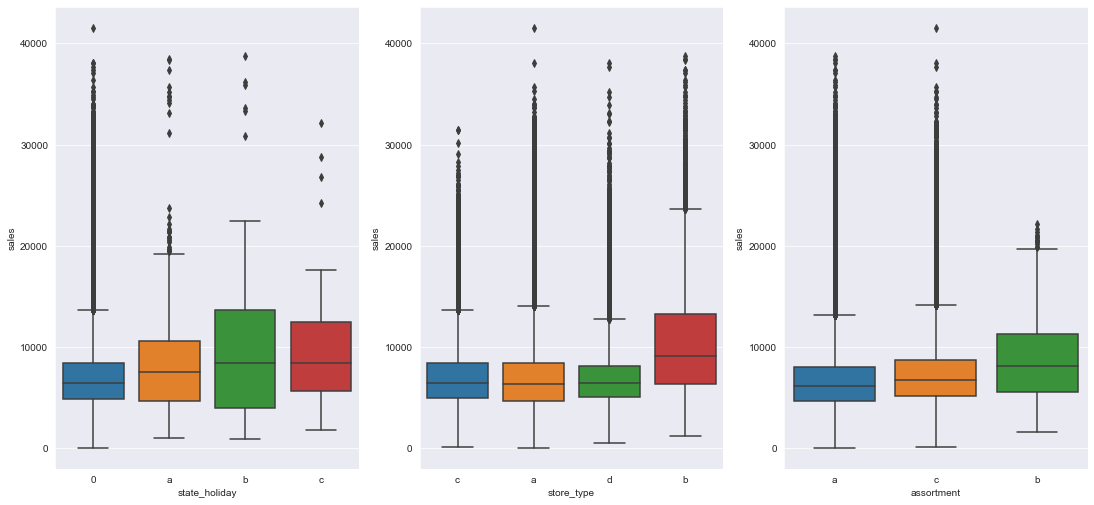

In [21]:
mask1=(df1['state_holiday']!=0) & (df1['sales']>0)
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=df1[mask1],palette='tab10')

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=df1[mask1],palette='tab10')

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=df1[mask1],palette='tab10')


fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)

# Hypoteshis Creation

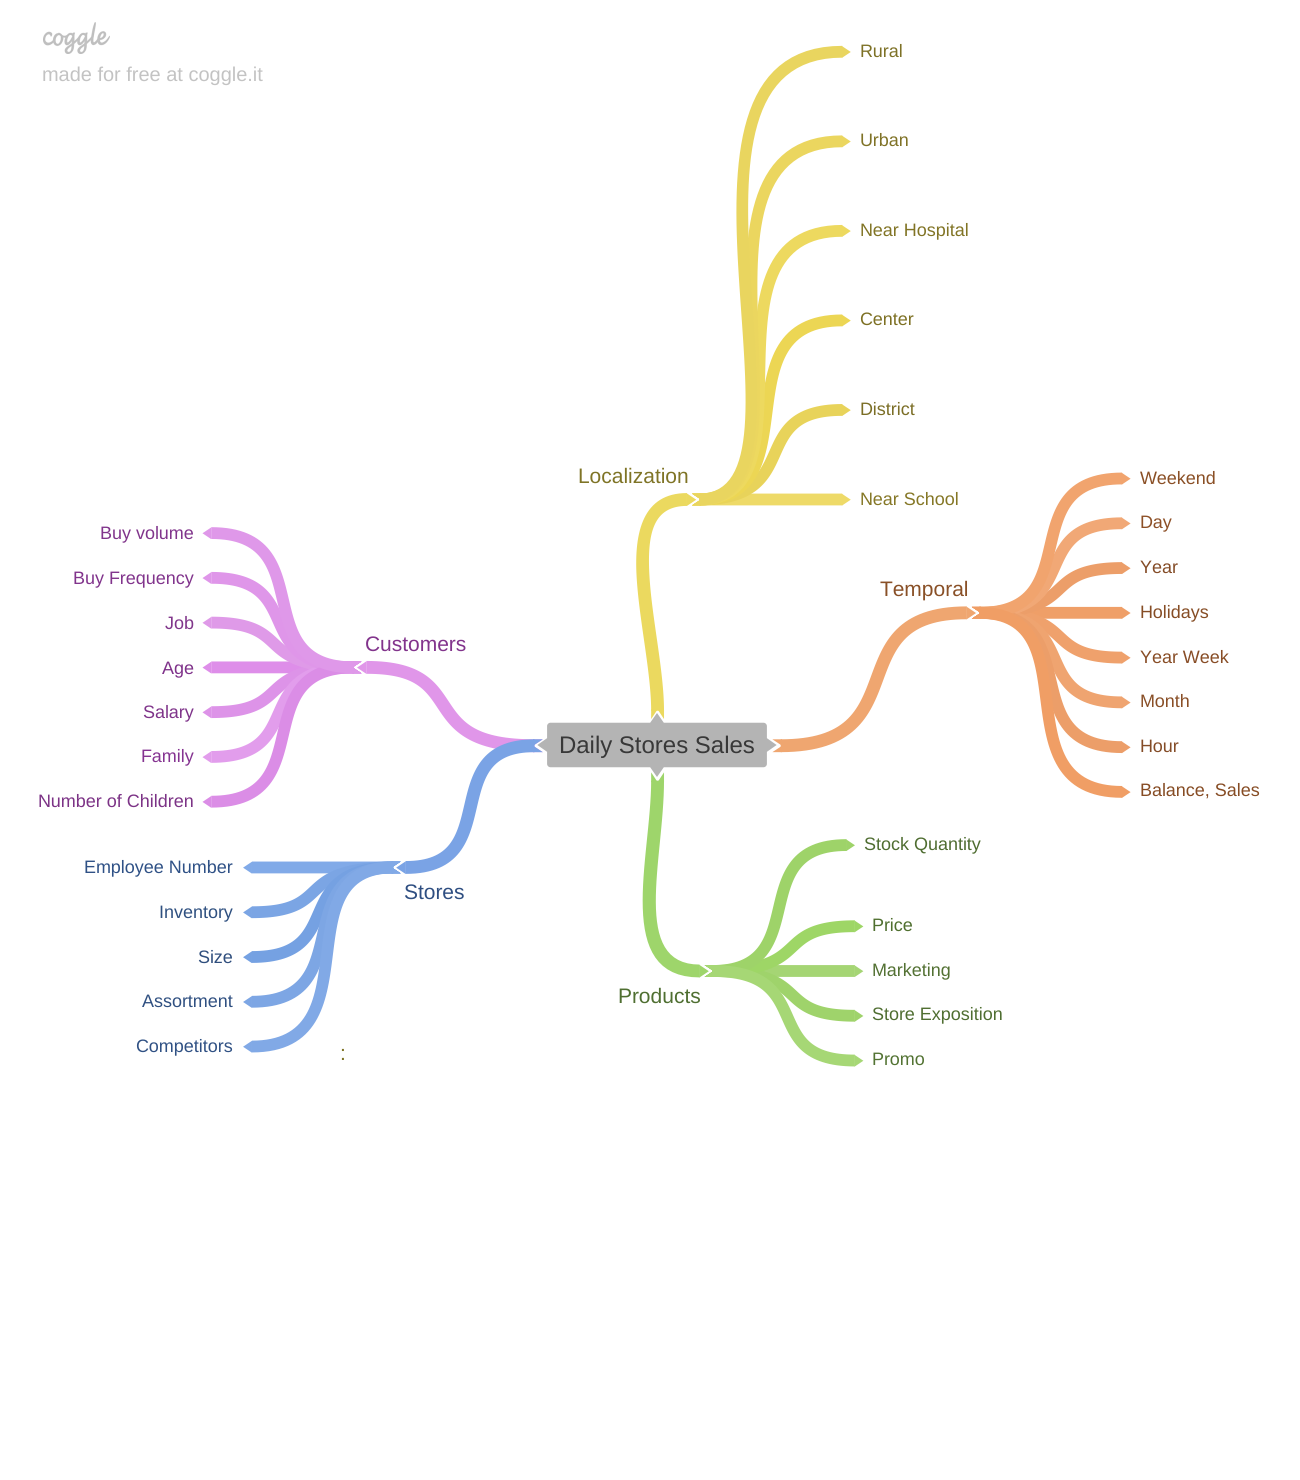

In [22]:
Image('img/Daily_Stores_Sales.png')

In [23]:
df2=df1.copy()

## Feature Engineering

In [24]:
import datetime

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# Feature filter

In [26]:
df3=df2.copy()

## row filtering

In [27]:
df3=df3[(df3['open']!=0) & (df3['sales']>0)]

## cols filtering

In [28]:
cols_drop = ['customers','open','promo_interval','month_map']
df3.drop(cols_drop,axis=1)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,9,2006,0,1,2013,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,10,1999,0,1,2013,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,1,2013,1,48,2012,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,1,2013,0,1,2013,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# Univariate Analysis

In [30]:
df4=df3.copy()

Numeric

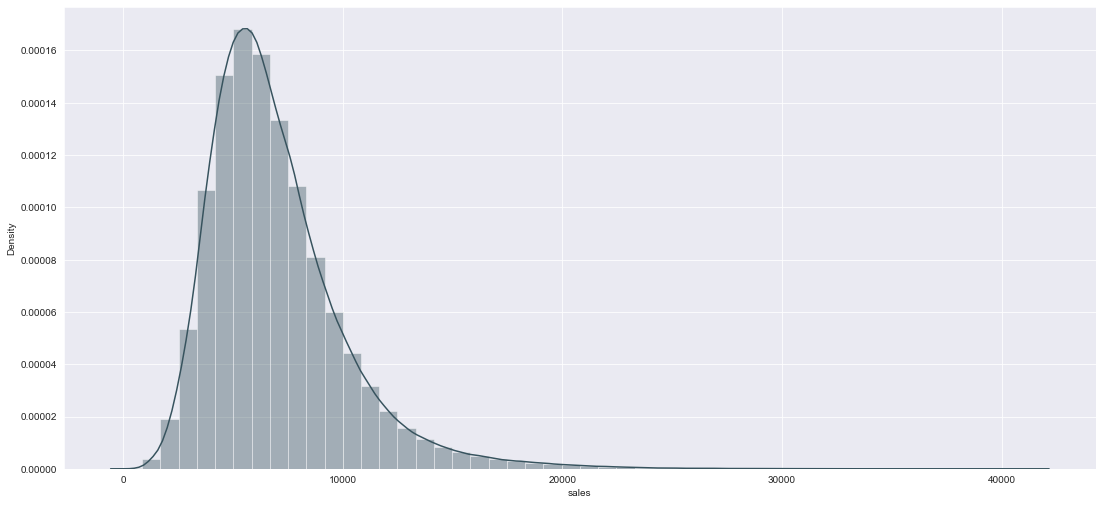

In [31]:
sns.distplot(df4['sales'])
fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)


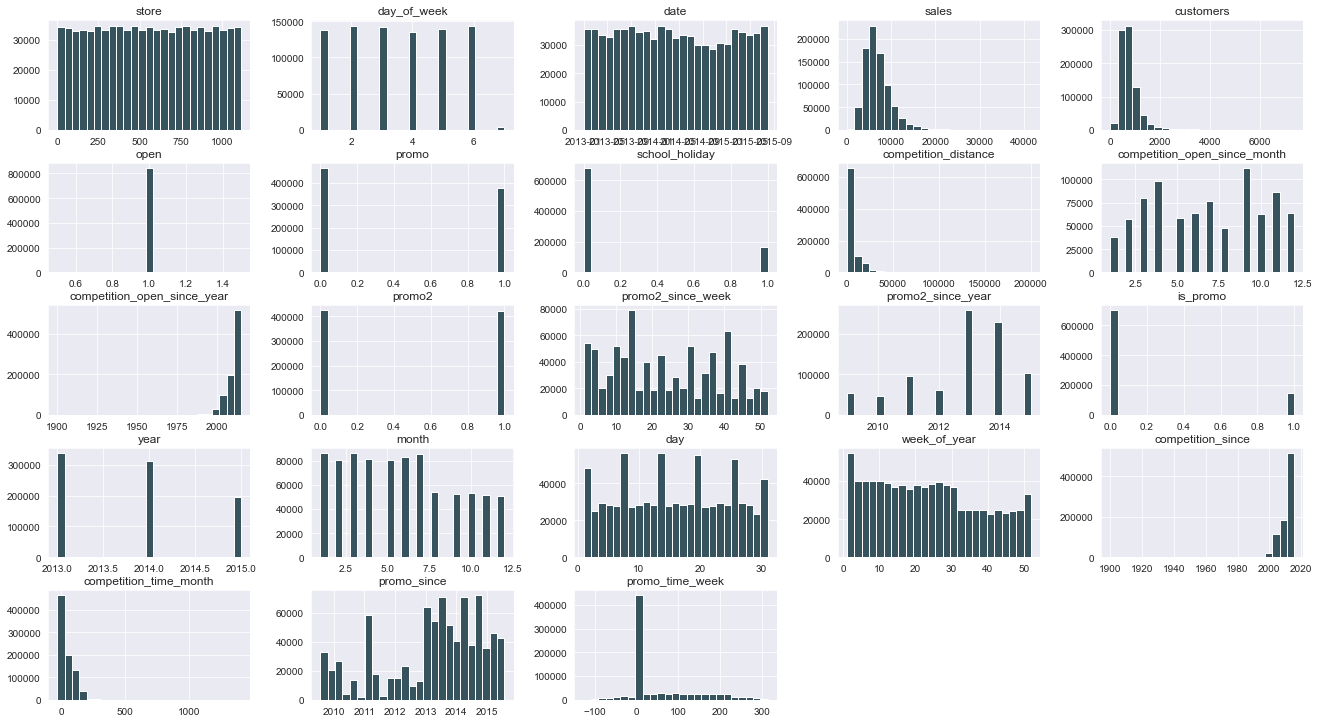

In [32]:
df4.hist(bins=25)
fig = plt.gcf()
fig.set_size_inches(22.5, 12.5)

Categoric

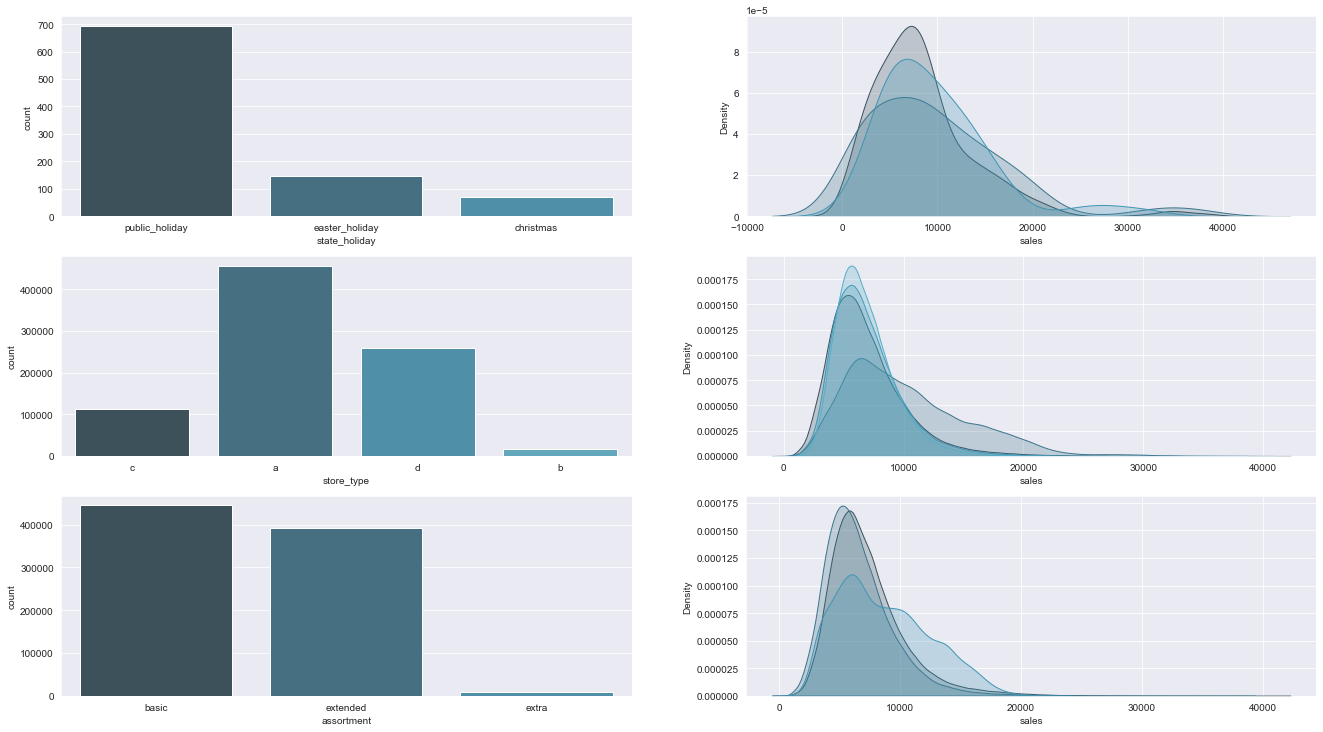

In [33]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

fig = plt.gcf()
fig.set_size_inches(22.5, 12.5)

# Bivariate analysis and hypoteses testing

## H1. Stores with larger assortments should sell more.
**FALSE** Stores with larger assortment sell less

<AxesSubplot:xlabel='year_week'>

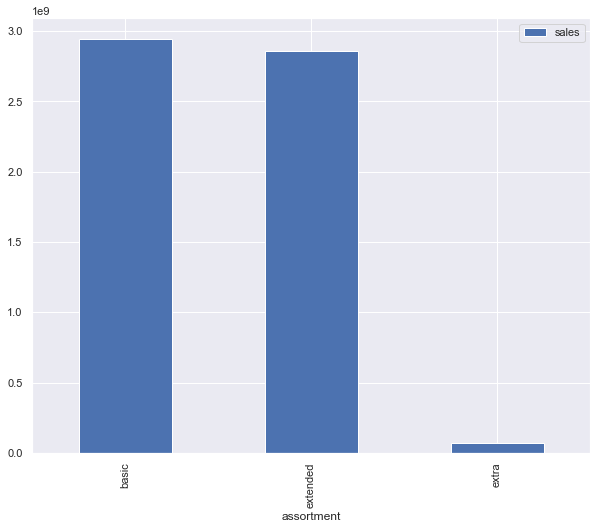

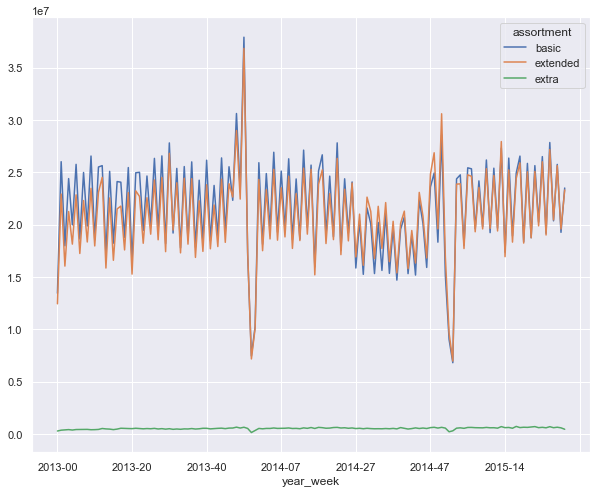

In [34]:
sns.set(rc={'figure.figsize':(10,8)})

df4.pivot_table(index='assortment',values='sales',aggfunc='sum').plot(kind='bar')

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

## H2. Stores with closer competitors should sell less.
**FALSE** Stores with CLOSER COMPETITORS sell LESS

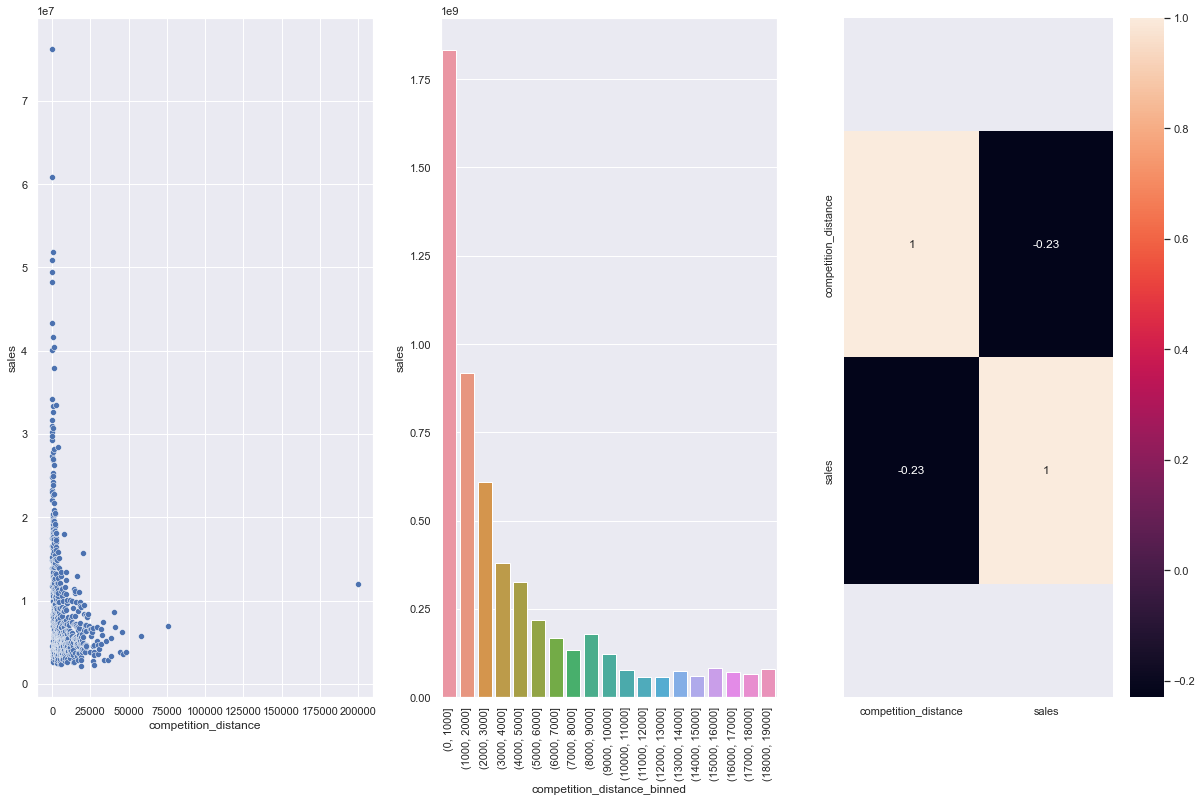

In [35]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

## **H3.** Store with longer competitors should sell less
**FALSE** Stores with LONGER COMPETITORS sell less

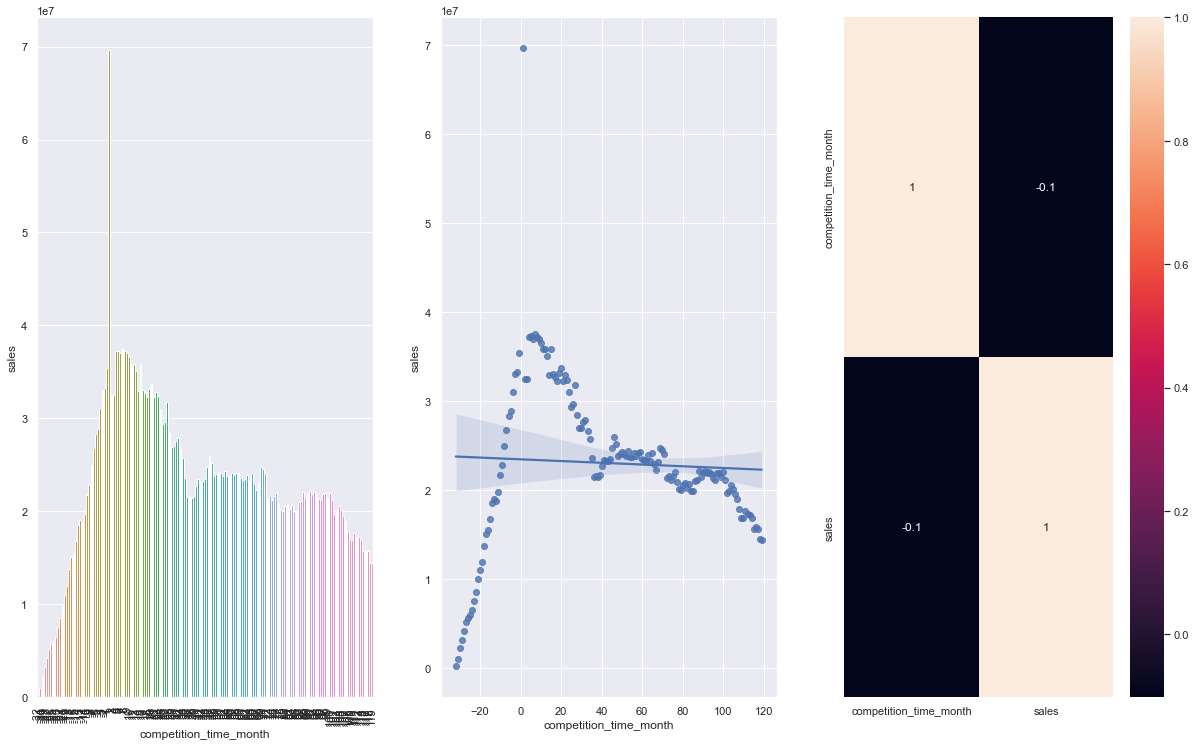

In [36]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 )
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 )

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True )
plt.xticks( rotation=0 );


fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

## **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

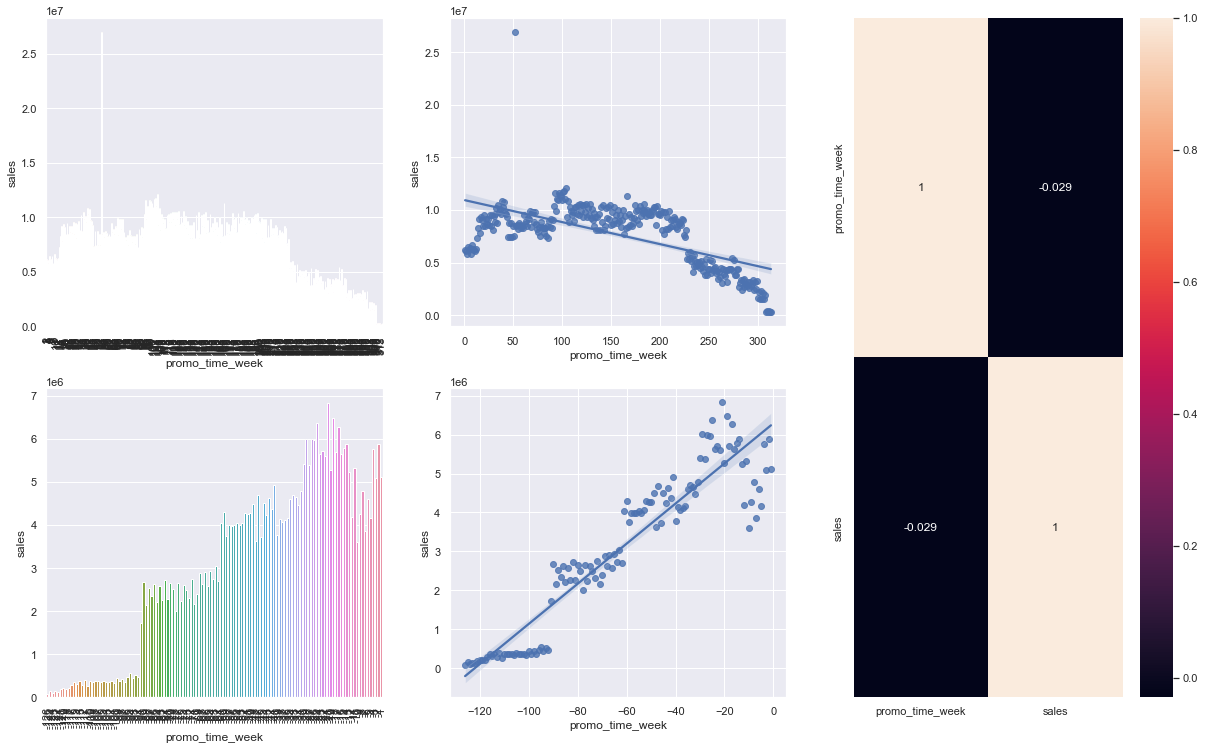

In [37]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

from matplotlib import gridspec

grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

## <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

## **H7.** Stores with more consecutives promotions should sell more
**FALSE** Stores with more consecutives promotions sell less

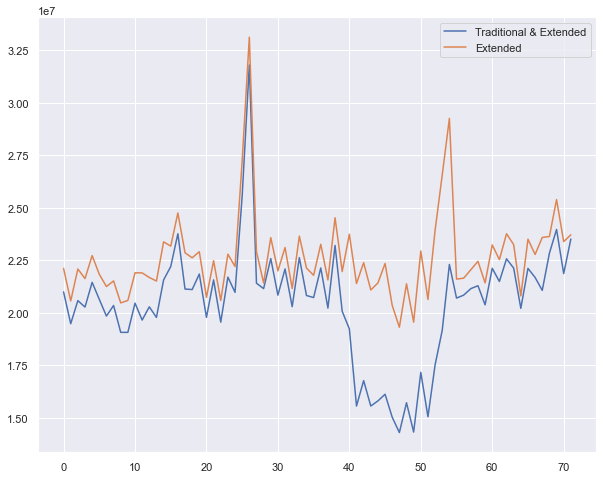

In [38]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Traditional & Extended', 'Extended']);

## H8 Stores open on Christmas Holiday should sell more.

**FALSE** Stores open on christmas holiday sell less.

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


## H9. Stores should sell more over the years.
**FALSE** Stores sell less over the years


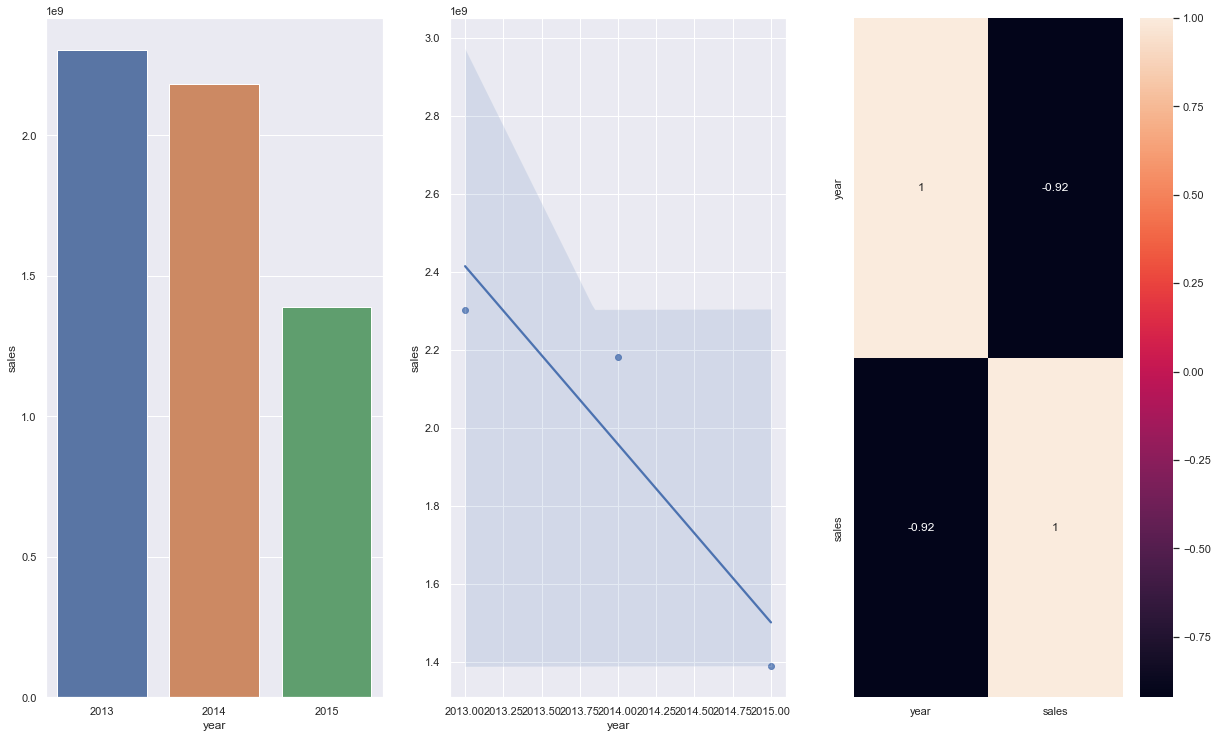

In [49]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.gcf().set_size_inches(20.5,12.5)

In [ ]:
9. Stores should sell more over the years.
10. Stores should sell more in the second half of the year.
11. Stores should sell more after the 10th of each month.
12. Stores should sell less on weekends.
13. Stores should sell less during school holidays.

## H10 Stores should sell more in the second half of the year.
**FALSE** Stores sell less in the second half of the year

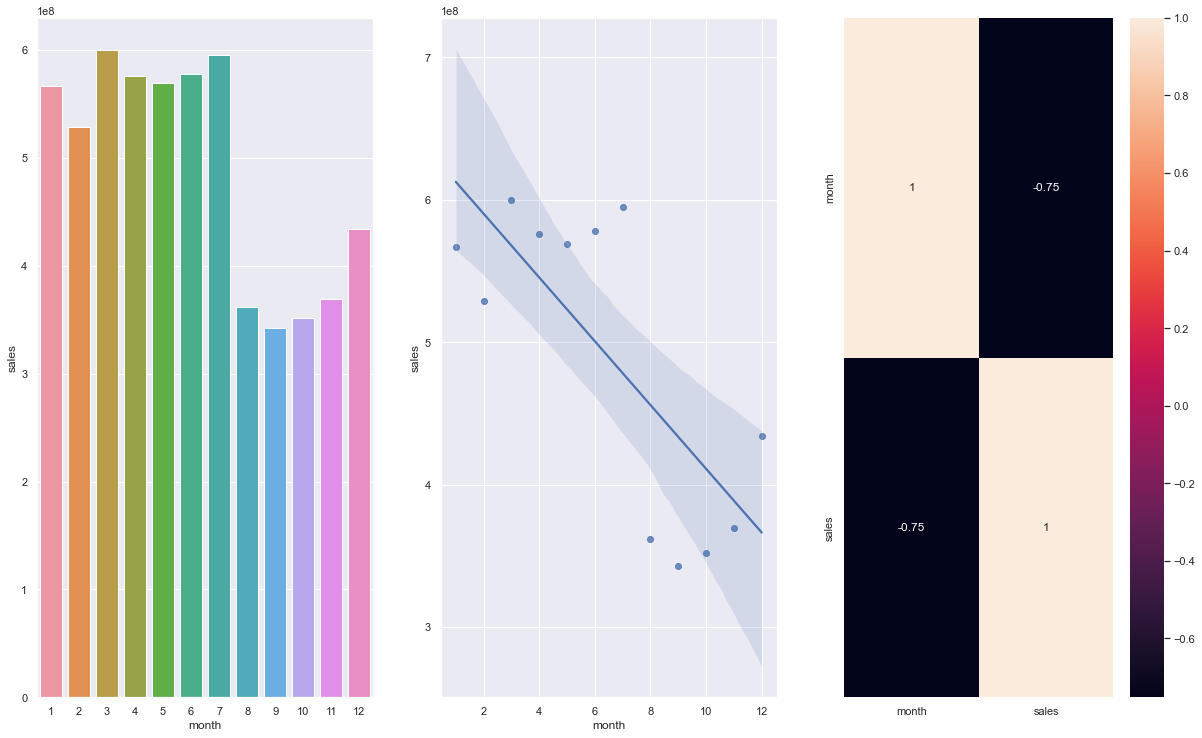

In [52]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.gcf().set_size_inches(20.5,12.5)

## H11 Stores should sell more after the 10th of each month.
**TRUE** Stores sell more after the 10th of each month.

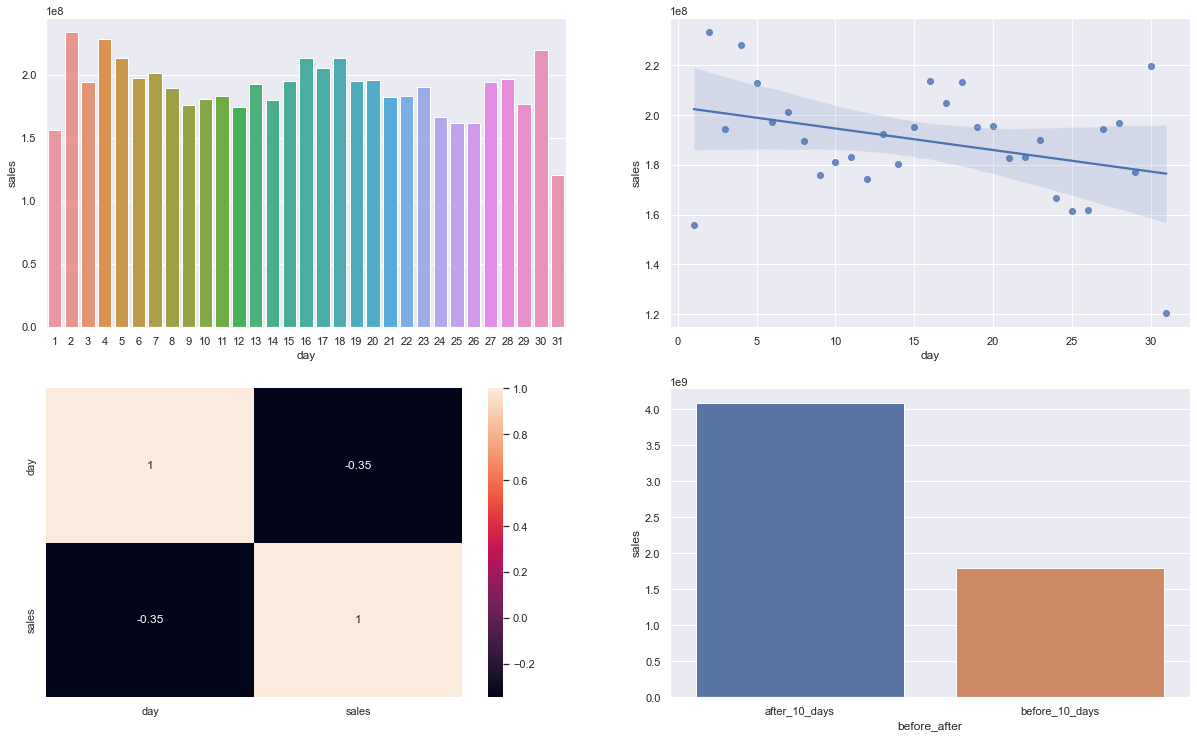

In [64]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.gcf().set_size_inches(20.5,12.5)


plt.subplot( 2, 2, 4)
aux1['before_after']= np.where(aux1['day']<10,'before_10_days','after_10_days')
aux2=aux1[['before_after','sales']].groupby( 'before_after').sum().reset_index()
sns.barplot(x='before_after',y='sales',data=aux2);

## H12 Stores should sell less on weekends.
**TRUE** Stores sell less after the 10th of each month.

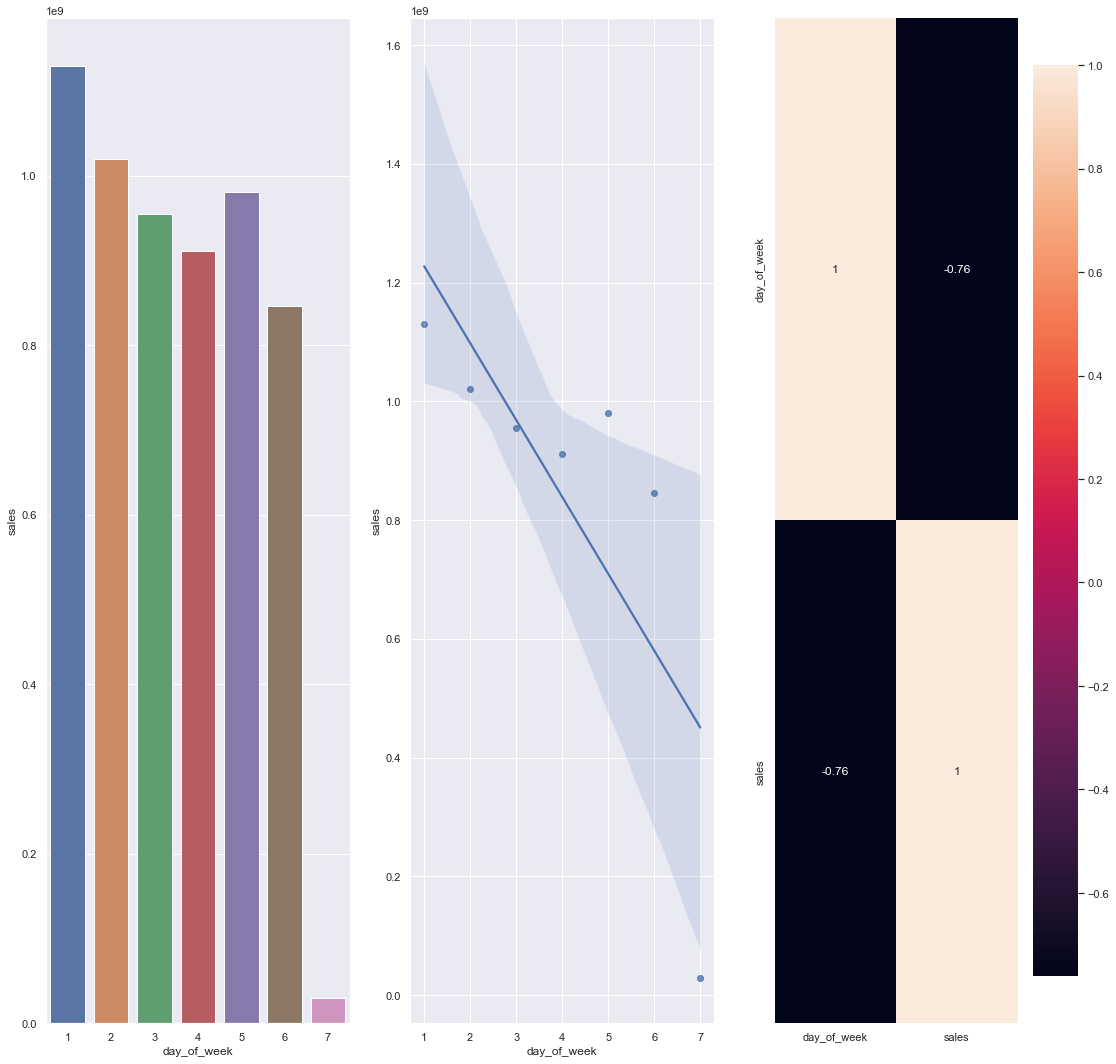

In [69]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.gcf().set_size_inches(18.5,18.5)

## H13 Stores should sell less during school holidays.
**TRUE** Stores sell less during school holidays, expect on July and August

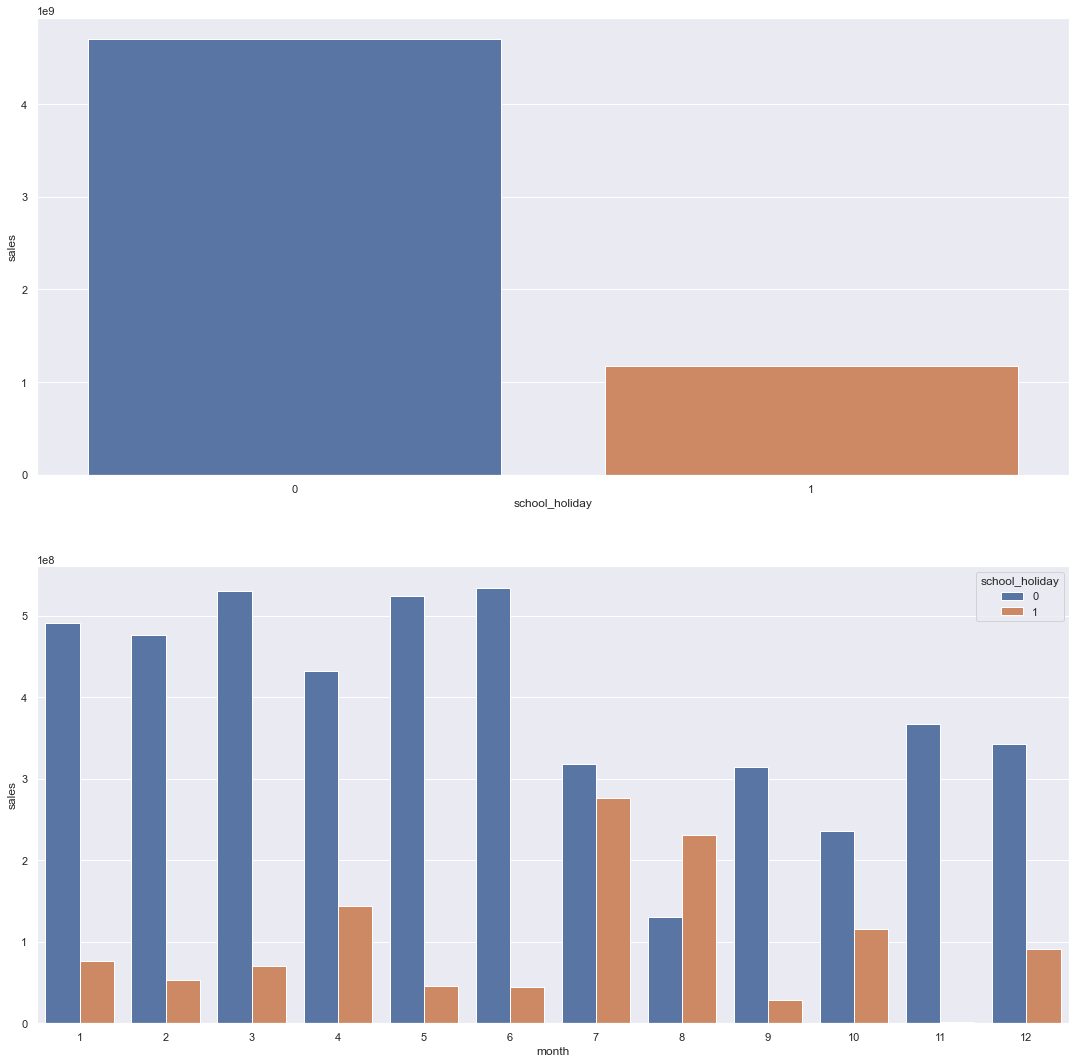

In [73]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );
plt.gcf().set_size_inches(18.5,18.5)